In [45]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
import keras
import optuna

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, minmax_scale
from path import Path

In [2]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_id = test['PassengerId']

## Analyze the Data

可以看到cabin的na很多，ticket的意义不大，这两个feature直接丢掉。

In [12]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
data.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

In [15]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


name 里面有个title和家族名值得提取，可能会有有用的信息。

In [16]:
data['Titles'] = [re.search(r'\b([A-Za-z]+)\.', name)[0] for name in data['Name']]
data['Family'] = [re.search(r'\b([A-Za-z]+)\,', name)[0] for name in data['Name']]

In [17]:
#data.drop(['Name'], axis=1, inplace=True)
data.drop(['Family', 'Name'], axis=1, inplace=True)

In [18]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3,17
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr.
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN,644,517
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN


我们的特征已经处理好了，里面还有些缺失值，先不管
编码一下字符特征

In [3]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

le = LabelEncoder()

In [ ]:
for str_feature in ['Titles', 'Sex', 'Embarked']:
    data[str_feature] = le.fit_transform(data[str_feature])

In [20]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles
0,1,0,3,1,22.0,1,0,7.2500,2,12
1,2,1,1,0,38.0,1,0,71.2833,0,13
2,3,1,3,0,26.0,0,0,7.9250,2,9
3,4,1,1,0,35.0,1,0,53.1000,2,13
4,5,0,3,1,35.0,0,0,8.0500,2,12


In [9]:
def data_preprocessing(data):
    data.drop(['Ticket', 'Cabin'], axis=1, inplace=True)
    data['Titles'] = [re.search(r'\b([A-Za-z]+)\.', name)[0] for name in data['Name']]
    data.drop(['Name'], axis=1, inplace=True)
    
    for str_feature in ['Titles', 'Sex', 'Embarked']:
        data[str_feature] = le.fit_transform(data[str_feature])
        
    data.drop(['PassengerId', 'Titles'], axis=1, inplace=True)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Age'] = minmax_scale(data['Age'])
    data['Fare'] = minmax_scale(data['Fare'])
    
    return data

# Train test split

In [25]:
from sklearn.model_selection import train_test_split
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_id = test['PassengerId']

test = data_preprocessing(test)
train = data_preprocessing(train)

x = train.drop('Survived', axis=1)
y = train['Survived']

# Model Training

## LGBM

In [43]:
class LGBConfig:
    input_path = Path('data')
    optuna_lgb = True
    n_estimators = 1500
    early_stopping_round = 150
    cv_folds = 5
    random_state = 0
    params = {'objective': 'binary',
              'boosting_type': 'gbdt',
              'learning_rate': 0.01,
              'max_bin': 25,
              'num_leaves': 31,
              'min_child_samples': 1500,
              'colsample_bytree': 0.7,
              'subsample_freq': 1,
              'subsample': 0.7,
              'reg_alpha': 1.0,
              'reg_lambda': 1.0,
              'verbosity': 0,
              'random_state': 0}
    
lgb_config = LGBConfig()

In [53]:

params = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 1.0),
        'num_leaves': trial.suggest_int("num_leaves", 3, 255),
        'min_child_samples': trial.suggest_int("min_child_samples", 3, 3000),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'subsample_freq': trial.suggest_int("subsample_freq", 0, 10),
        'subsample': trial.suggest_float("subsample", 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-9, 10.0),
}

NameError: name 'trial' is not defined

In [61]:
# wrap the metric for lgb
def roc_auc_lgb(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

In [62]:
score = []
skf = StratifiedKFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)

for train_idx, valid_idx in skf.split(x, y):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]

    model = lgb.LGBMClassifier(
                            n_estimators=1500,
                            early_stopping_round=150,
                            force_row_wise=True)

    callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=False)]
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric=roc_auc_lgb, callbacks=callbacks)
    score.append(model.best_score_['valid_0'])

TypeError: cannot unpack non-iterable numpy.float64 object

[OrderedDict([('binary_logloss', 0.3740816220483688)]),
 OrderedDict([('binary_logloss', 0.3831890292695847)]),
 OrderedDict([('binary_logloss', 0.41431547472692676)]),
 OrderedDict([('binary_logloss', 0.4339083608521496)]),
 OrderedDict([('binary_logloss', 0.4893750281818295)])]

In [52]:
 from sklearn.model_selection import StratifiedKFold
 from sklearn.metrics import roc_auc_score, accuracy_score
 
 if lgb_config.optuna_lgb:
        
    def objective(trial):
        params = {
                'learning_rate': trial.suggest_float("learning_rate", 0.01, 1.0),
                'num_leaves': trial.suggest_int("num_leaves", 3, 255),
                'min_child_samples': trial.suggest_int("min_child_samples", 3, 3000),
                'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
                'subsample_freq': trial.suggest_int("subsample_freq", 0, 10),
                'subsample': trial.suggest_float("subsample", 0.1, 1.0),
                'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-9, 10.0),
                'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-9, 10.0),
        }
        
        score = []
        skf = StratifiedKFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)

        for train_idx, valid_idx in skf.split(x, y):
            x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
            x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]

            model = lgb.LGBMClassifier(**params,
                                    n_estimators=1500,
                                    early_stopping_round=150,
                                    force_row_wise=True)

            callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=False)]
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], callbacks=callbacks)
            score.append(model.best_score_['valid_0'])

        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=300)

    print("Best Score", study.best_value)
    print("Best parameters", study.best_params)
    
    params = {'objective': 'binary',
            'boosting_type': 'gbdt',
            'verbosity': 0,
            'random_state': 0}
    
    params.update(study.best_params)
else:
    params = lgb_config.params

[I 2023-12-05 17:09:12,648] A new study created in memory with name: no-name-dcc8452e-fb58-4550-bb30-d5554c533500


[W 2023-12-05 17:09:12,815] Trial 0 failed with parameters: {'learning_rate': 0.6032064259009265, 'num_leaves': 10, 'min_child_samples': 1070, 'colsample_bytree': 0.8209945056890007, 'subsample_freq': 10, 'subsample': 0.16726013927955857, 'reg_alpha': 0.2009686748965938, 'reg_lambda': 0.0017789921843907102} because of the following error: The value OrderedDict([('binary_logloss', 0.6931634120601291)]) could not be cast to float.
[W 2023-12-05 17:09:12,828] Trial 0 failed with value [OrderedDict([('binary_logloss', 0.6931634120601291)]), OrderedDict([('binary_logloss', 0.689134547172488)]), OrderedDict([('binary_logloss', 0.689134547172488)]), OrderedDict([('binary_logloss', 0.689134547172488)]), OrderedDict([('binary_logloss', 0.6957178790893654)])].
[W 2023-12-05 17:09:12,985] Trial 1 failed with parameters: {'learning_rate': 0.31270465835274686, 'num_leaves': 18, 'min_child_samples': 775, 'colsample_bytree': 0.16132913065814922, 'subsample_freq': 0, 'subsample': 0.6229573371047595, '

ValueError: No trials are completed yet.

In [39]:
preds = np.zeros(len(test))
oof = np.zeros(len(train))
metric_evaluations = []

skf = StratifiedKFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)

for idx, (train_idx, valid_idx) in enumerate(skf.split(x, y)):
    print(f"CV fold {idx}")
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]
    
    model = lgb.LGBMClassifier(**params,
                               n_estimators=lgb_config.n_estimators,
                               early_stopping_round=lgb_config.early_stopping_round,
                               force_row_wise=True)
    
    callbacks=[lgb.early_stopping(stopping_rounds=150), 
               lgb.log_evaluation(period=100, show_stdv=False)]
                                                                                           
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='roc_auc_score', callbacks=callbacks)
    metric_evaluations.append(model.best_score_['valid_0'])
    preds += model.predict_proba(test, num_iteration=model.best_iteration_)[:,1] / skf.n_splits
    oof[valid_idx] = model.predict_proba(x_valid, num_iteration=model.best_iteration_)[:,1]

CV fold 0
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 150 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

## NN

In [272]:
import tensorflow as tf
import keras


seed = 42
keras.utils.set_random_seed(seed)
keras.backend.backend(), keras.__version__

('tensorflow', '3.0.0')

In [273]:
input_dim = x.shape[1]

nn_clf = keras.Sequential(
    [
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(12, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(6, activation='relu'),
        #keras.layers.Dropout(0.2),
        #keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

nn_clf.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 12)                │         96 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_14 (Dropout)            │ (None, 12)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_43 (Dense)                │ (None, 6)                 │         78 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_44 (Dense)                │ (None, 1)                 │          7 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

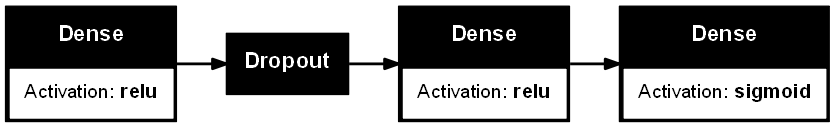

In [274]:
keras.utils.plot_model(nn_clf, show_layer_activations=True, dpi=100, rankdir="LR")

In [275]:
optimzer = keras.optimizers.Adam(learning_rate=0.002)

nn_clf.compile(
    optimizer = optimzer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

In [276]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=20,verbose=1, restore_best_weights=True),
]

history = nn_clf.fit(x=x_train, y=y_train, epochs=500, verbose=2, 
                     validation_split=0.15,
                     shuffle=True,
                     callbacks=my_callbacks)

Epoch 1/500


19/19 - 4s - 221ms/step - accuracy: 0.3851 - loss: 0.9765 - val_accuracy: 0.4486 - val_loss: 0.7560
Epoch 2/500
19/19 - 0s - 8ms/step - accuracy: 0.3934 - loss: 0.7763 - val_accuracy: 0.4393 - val_loss: 0.6993
Epoch 3/500
19/19 - 0s - 7ms/step - accuracy: 0.4777 - loss: 0.7110 - val_accuracy: 0.5701 - val_loss: 0.6872
Epoch 4/500
19/19 - 0s - 8ms/step - accuracy: 0.5934 - loss: 0.6741 - val_accuracy: 0.5421 - val_loss: 0.6798
Epoch 5/500
19/19 - 0s - 7ms/step - accuracy: 0.6050 - loss: 0.6589 - val_accuracy: 0.5514 - val_loss: 0.6717
Epoch 6/500
19/19 - 0s - 7ms/step - accuracy: 0.6298 - loss: 0.6399 - val_accuracy: 0.5514 - val_loss: 0.6682
Epoch 7/500
19/19 - 0s - 8ms/step - accuracy: 0.6463 - loss: 0.6206 - val_accuracy: 0.5514 - val_loss: 0.6633
Epoch 8/500
19/19 - 0s - 7ms/step - accuracy: 0.6496 - loss: 0.6144 - val_accuracy: 0.5981 - val_loss: 0.6555
Epoch 9/500
19/19 - 0s - 7ms/step - accuracy: 0.6678 - loss: 0.6090 - val_accuracy: 0.6075 - val_loss: 0.6434
Epoch 10/500
19/19 -

<Axes: xlabel='epochs', ylabel='loss'>

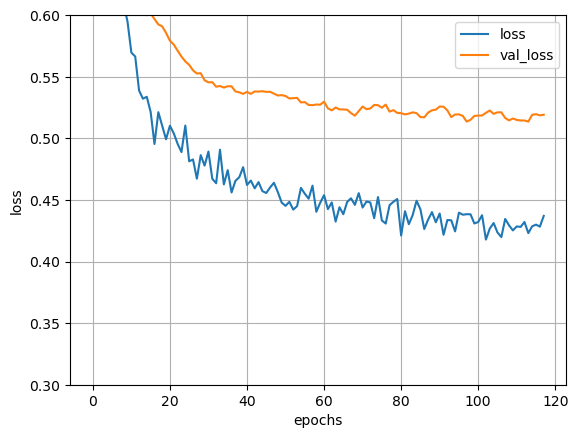

In [277]:
train_log = pd.DataFrame(history.history)
train_log[['loss', 'val_loss']].plot(
    xlabel='epochs',
    ylabel='loss',
    ylim=(0.3,0.6),
    grid=True
)

In [157]:
# 保存一下模型
# nn_clf.save('nn_model4.h5')
# nn_clf = keras.saving.load_model('titanic_0.78947.h5')

In [250]:
y_pred = nn_clf.predict(x)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [251]:
proba_gamma = 0.5
accuracy_score(y, y_pred>proba_gamma)

0.8249158249158249

In [252]:
roc_auc_score(y, y_pred>0.5)

0.8033505895887258

<Axes: ylabel='Proportion'>

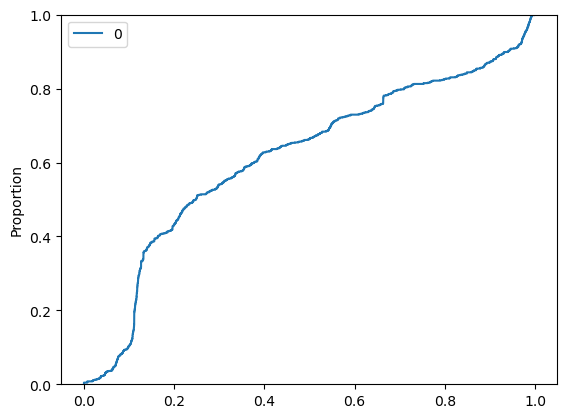

In [247]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.ecdfplot(y_pred)

In [248]:
result = nn_clf.predict(test).flatten()
result = np.where(result>proba_gamma, 1, 0)
result = pd.DataFrame(result, columns=['Survived'])
result['PassengerID'] = test_id
result.to_csv('result.csv', index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


# Ensemble

In [93]:
lgbm_pred = lgbm_clf.predict_proba(test)[:,1]
nn_pred = nn_clf.predict(test).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [94]:
ensemble_pred = np.where((lgbm_pred + nn_pred) > 0.9, 1, 0)

In [95]:
accuracy_score(y_test, ensemble_pred)

ValueError: Found input variables with inconsistent numbers of samples: [179, 418]

In [96]:
result = pd.DataFrame(ensemble_pred, columns=['Survived'])
result['PassengerID'] = test_id
result.to_csv('ensemble_result.csv', index=False)

# OUTPUT

In [315]:
test_result = test.copy()
test_result['Survived'] = lgbm_clf.predict(test)
test_result = test_result[['PassengerId', 'Survived']]
test_result.to_csv('test_result.csv', index=False)